In [1]:
import os
import shutil
from IPython.display import display, Image as im
import unittest

import numpy as np
from numpy import array
from PIL import Image, ImageDraw
np.seterr(divide='ignore', invalid='ignore')

string_mode = True
ncc_mode = True
width = 10
top = 3
threshold = 3
delete_threshold = 100
bin_ratio = 600

binary_path = os.getcwd() + '/binary/'
found_path = os.getcwd() + '/found/'
cutted_path = os.getcwd() + '/cutted/'
lines_path = found_path + 'lines/'

def_input_address = 'test.png'
def_examples_path = os.getcwd() + '/examples/'
def_empty_threshold = 65
def_lines_threshold = 20

bin_examples = []
names = []
nccors = []
spaces = []

RESULT = ''

In [2]:
def ui(def_input_address, def_examples_path, def_empty_threshold, 
       def_lines_threshold): #inputs check
    """
    User interface receives the defaults. The user can define values 
    or they will be returned by default.
    
    """
    
    input_address = input('Enter the image address (default is ' + 
                          def_input_address + ') :')
    if input_address == '': 
        input_address = def_input_address

    examples_path = input('Enter the path to folder with samples ' +
                          '(default is ' + def_examples_path + '):')
    if examples_path == '': 
        examples_path = def_examples_path
    
    empty_threshold = input('Enter the distance between letters ' +
                            '(default is ' + str(def_empty_threshold) + 
                            ') [px]:')
    if empty_threshold == '': 
        empty_threshold = def_empty_threshold
        
    empty_lines_threshold = input('Enter the distance between lines ' +
                                  '(default is ' + 
                                  str(def_lines_threshold) + ') [px]:')
    if empty_lines_threshold == '': 
        empty_lines_threshold = def_lines_threshold
    
    erase_flag = input('Clear examples after the previous ' + 
                       'preprocessing? [y/N]:')
    return (erase_flag, input_address, examples_path, 
            empty_threshold, empty_lines_threshold)

In [3]:
def create_folders(examples_path, binary_path, found_path, 
                   cutted_path, lines_path):
    """
    The function creates folders that will be filled by generated images.
    
    """
    
    folders = [examples_path, binary_path, found_path, cutted_path]
    names = ['examples','binary','found','cutted']
    for i in range(len(folders)):
        if not os.path.exists(folders[i]):
            os.mkdir(names[i])
            f = os.getcwd() + '/' + names[i] + '/'
    
    if not os.path.exists(lines_path):
            os.mkdir(found_path + 'lines/')
            f = found_path + 'lines/'
                
    for d, dirs, files in os.walk(examples_path):
            for f in dirs:
                if not os.path.exists(binary_path + f):
                    os.mkdir(binary_path + f)
                    os.mkdir(cutted_path + f)

In [4]:
def delete_folders(binary_path, found_path, cutted_path):
    """
    The function deletes the folders that were filled by generated images.
    
    """
    
    folders = [binary_path, found_path, cutted_path]
    for f in folders:
        if os.path.exists(f):   
            shutil.rmtree(f)

In [5]:
def binarization(input_img_addr):
    """
    The function takes an image and saves a copy in which all pixels 
    are only black or white in /binary.
    
    """
    
    #convert to 'RGBA' for .gif opening fix
    input_image  = Image.open(input_img_addr).convert('RGBA')
    draw = ImageDraw.Draw(input_image)
     
    for i in range(input_image.size[0]):
        for j in range(input_image.size[1]):
            r, g, b, a = input_image.getpixel((i, j))
            if a == 0:
                r, g, b = 0, 0, 0
            if (r + g + b > bin_ratio): 
                r, g, b = 255, 255, 255
            else:
                r, g, b = 0, 0, 0 
            draw.point((i, j), (r, g, b))
    del draw
    
    input_img_addr = input_img_addr[:-4] + '.png'
    input_image.save(input_img_addr.replace('/examples/', 
                                            '/binary/'), "PNG")

In [6]:
def separation(input_img_addr, threshold, 
               empty_threshold, empty_lines_threshold):
    """
    The function takes the image, cuts it into rows by a horizontal lines 
    if the line and previous [empty_lines_threshold] lines contained 
    less than [threshold] black pixels in each. 
    The resulting images are saved in /found/lines. 
    Function cuts the images from /found/lines on the characters by a vertical 
    lines if the previous line and [empty_threshold] lines contained less 
    than [threshold] black pixels in each.
    The resulting images are saved in /found.
    
    """
    
    global spaces
    
    input_image = Image.open(input_img_addr).convert('L')
    
    x0 = 0
    y0 = 0
    x1 = 0
    y1 = 0

    symbolsx = []
    symbolsy = []

    black = 0
    symbol = False
    empty = 0
    
    if string_mode:
        for y in range(input_image.size[1]):
            for x in range(input_image.size[0]):
                pix = input_image.getpixel((x, y))
                if pix < 255:
                    black += 1
            if symbol == True and black < threshold:
                empty += 1
            if symbol == False and black > threshold:
                y0 = y
                symbol = True
            if (symbol == True and black <= threshold and 
                empty >= int(empty_lines_threshold)):
                y1 = y
                symbol = False
                symbolsy.append((y0, y1))
                empty = 0
            black = 0
    
        if symbolsx == []:
            symbolsx = [(0, input_image.size[0])] 
        if symbolsy == []:
            symbolsy = [(0, input_image.size[1])] 

        count = 0

        for y in symbolsy:
            for x in symbolsx:
                if count < 1000:
                    temp = '{:03d}'.format(count)
                    addr = found_path + '/lines/' + str(temp) + '.png'
                    input_image.crop((x[0], y[0], 
                                      x[1], y[1])).save(addr, "PNG")
                count += 1
                
    
    lines = os.listdir(found_path + '/lines')
    scount = 0
    try:
        for l in sorted(lines):
            input_image = Image.open(found_path + 
                                     'lines/' + l).convert('L')
            
            x0 = 0
            y0 = 0
            x1 = 0
            y1 = 0

            symbolsx = []
            symbolsy = []

            black = 0
            symbol = False
            empty = 0

            for x in range(input_image.size[0]):
                for y in range(input_image.size[1]):
                    pix = input_image.getpixel((x, y))
                    if pix < 255:
                        black += 1
                if symbol == True and black < threshold:
                    empty += 1
                if symbol == False and black > threshold: 
                    x0 = x
                    symbol = True
                if (symbol == True and black <= threshold and 
                    empty >= int(empty_threshold)):
                    x1 = x
                    symbol = False
                    scount+=1
                    symbolsx.append((x0, x1))
                    empty = 0
                black = 0


            if symbolsx == []:
                symbolsx = [(0, input_image.size[0])] 
            if symbolsy == []:
                symbolsy = [(0, input_image.size[1])] 

            for y in symbolsy:
                for x in symbolsx:
                    if count < 1000:
                        temp = '{:03d}'.format(count)
                        addr = 'found/' + str(temp) + '.png'
                        input_image.crop((x[0], y[0], 
                                          x[1], y[1])).save(addr, "PNG")
                    count += 1
            spaces.append(scount)
    except IOError:
            pass

In [7]:
def delete_trash(threshold):
    """
    The function deletes the images from /found if the number 
    of black pixels in it less than [delete_threshold].
    
    """
    
    images = os.listdir(found_path)
    for i in range(len(images)):
        try:
            black = 0
            input_image = Image.open(found_path + images[i])
            
            for x in range(input_image.size[0]):
                for y in range(input_image.size[1]):
                    pix = input_image.getpixel((x, y))
                    if pix != 255:
                        black += 1
            if black < threshold:
                os.remove(found_path + images[i])
        except IOError:
            pass        

In [8]:
def ncc(input_img_addr, example_addr): 
    """
    Function treat pixels of two images as vectors, normalizes them, 
    then takes their dot product.
    
    """
    
    global width
    input_image = Image.open(input_img_addr)
    wpercent = (width / float(input_image.size[0]))
    height = int((float(input_image.size[1]) * float(wpercent)))
    input_image = input_image.resize((width,height),Image.ANTIALIAS)
    example = Image.open(example_addr).resize((input_image.size[0],
                                               input_image.size[1]), 
                                              Image.ANTIALIAS)
    
    images = [input_image, example]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel in image.getdata():
            vector.append(np.mean(pixel))
        vectors.append(vector)
        norms.append(np.linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    res = np.dot(a / a_norm, b / b_norm)
    return res

In [9]:
def compare_1to1(input_img_addr, example_addr):
    """
    Comparison of 1 to 1. Helper function for filling in the results list.
    
    """
    
    input_img_addr = found_path + input_img_addr
    naive_cut(input_img_addr)

    if ncc_mode:
        nccors.append(ncc(input_img_addr, example_addr))
    
    names.append(example_addr.replace(cutted_path, '')[:-4]) 

In [10]:
def compare_1toN(input_img_addr):
    """
    The function calls the 1-to-1 for the found character and all examples.
    
    """
    
    global names, nccors, bin_examples
    names, nccors = [], []
    
    for i in range(len(bin_examples)):
        try:
            compare_1to1(input_img_addr, bin_examples[i])
        except IOError:
            pass

In [11]:
def result_1toN():
    """
    Function fills lists comparison results for each symbol.
    
    """
    
    results = []
    
    if ncc_mode and nccors != []:
        results.append(names[nccors.index(max(nccors))])
    
    if results == []:
        results = ['']
        
    temp = max(set(results), key=results.count)
    display(im(filename=binary_path + temp + '.png'))
    for d, dirs, files in os.walk(examples_path):
        for f in dirs:
            temp = temp.replace(f, '')
            temp = temp.replace('/', '') 
    return temp 

In [12]:
def print_top(top, tmp_arr, flag):
    """
    The function prints the top [top] of the local results.
    
    """
    
    for i in range(top):
        if flag == 'max':
            tmp = max(tmp_arr)
        if flag == 'min':
            tmp = min(tmp_arr)  
            
        print(str(i + 1) + ". :" + str(names[tmp_arr.index(max(tmp_arr))]) +
              " scores: " + str(max(tmp_arr)))
        tmp_arr.remove(max(tmp_arr))

In [13]:
def print_1toN(top):
    """
    The function prints a general result of the character recognition.
    
    """
    
    print('Results:')
    if ncc_mode and nccors != []:
        print('NCC mode:')
        print_top(top, nccors, 'max')
    print('Result:' + str(RESULT))

In [14]:
def naive_cut(img_address):
    """
    The function cuts the image on all sides by removing rows and columns in which 
    no black pixels.
    
    """
    
    img = Image.open(img_address).convert('L')
    arr = array(img)
    norm_arr = []
    find = False

    for c in range(4):
        black = 0
        find = False
        #img = Image.fromarray(arr)
        for x in range(len(arr[:, 1])):
            if find:
                break
            for y in range(len(arr[1, :])):
                if arr[x, y] == 0:
                    black += 1
            if black >= 1:
                arr = np.delete(arr, np.s_[0:x], axis=0)
                find = True
                break
        arr = np.rot90(arr)
        c += 1 
        
    
    img = Image.fromarray(arr)
    img.save(img_address.replace('binary', 'cutted'),"PNG")

In [15]:
def main():
    """
    The program takes a recognizable image and databases address.
    All images become a binary, then a recognizable image is cut, character by character.
    Images are cut and reduced, and then compared with each other and displayed the most 
    similar result.
    
    """
    
    global RESULT, input_address, empty_threshold, spaces
    global empty_lines_threshold, examples_path, top, bin_examples
    
    (erase_flag, input_address, examples_path, empty_threshold, 
     empty_lines_threshold) = ui(def_input_address, def_examples_path, 
                                 def_empty_threshold, def_lines_threshold)
    RESULT = ''
    
    try:
        binarization(input_address)
    except IOError:
        print('Error. Input image is not found.')
        return 0
    
    input_address = input_address[:-4] + '.png'
    display(im(filename=input_address))  
    
    if (erase_flag == 'y' or erase_flag == 'Y' or 
        not os.path.exists(binary_path)):
        delete_folders(binary_path, found_path, cutted_path)
        create_folders(examples_path, binary_path, 
                       found_path, cutted_path, lines_path)
        examples = []
        
        for d, dirs, files in os.walk(examples_path):
            for f in files:
                path = os.path.join(d, f)
                examples.append(path)   
                
        for i in range(len(examples)):
            try:
                binarization(examples[i])
                naive_cut(examples[i].replace('/examples/', '/binary/'))
            except IOError:
                pass
    
        for d, dirs, files in os.walk(cutted_path):
            for f in files:
                path = os.path.join(d, f)
                bin_examples.append(path)
    else:                
        if os.path.exists(found_path):
            shutil.rmtree(found_path)
        create_folders(examples_path, binary_path, found_path, 
                       cutted_path, lines_path)
        
        for d, dirs, files in os.walk(cutted_path):
            for f in files:
                path = os.path.join(d, f)
                bin_examples.append(path)
            
    separation(input_address, threshold, 
               empty_threshold, empty_lines_threshold)
    delete_trash(delete_threshold)
        
    symbols = os.listdir(found_path)
    count = 0
    for i in sorted(symbols):
        try:
            count += 1
            print('Processing:')
            try:
                display(im(filename=found_path + i))
            except:
                pass
            compare_1toN(i)
            RESULT += result_1toN().replace('0','')
            print_1toN(top)
            print('Processed: ' + str(count) + 
                  '/' + str(len(symbols) - 1))
            if count in spaces: RESULT += ' '
        except IOError:
            pass
    print('Message: ' + RESULT)
    RESULT = ''

Enter the image address (default is test.png) :
Enter the path to folder with samples (default is /home/cel/UJ/Python/gctranslator/examples/):
Enter the distance between letters (default is 65) [px]:
Enter the distance between lines (default is 20) [px]:
Clear examples after the previous preprocessing? [y/N]:


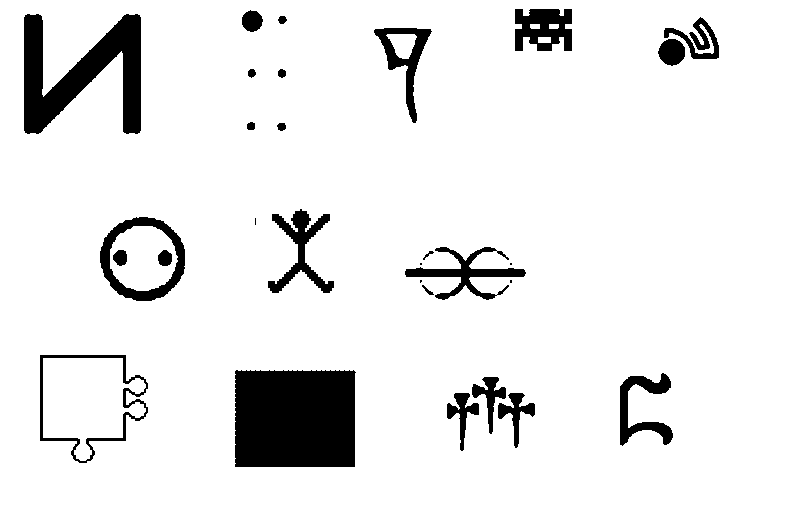

Processing:


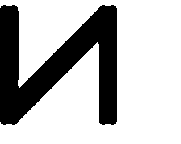

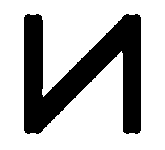

Results:
NCC mode:
1. :1/h scores: 1.0
2. :1/w scores: 0.909726030622
3. :1/g scores: 0.904388427825
Result:h
Processed: 1/12
Processing:


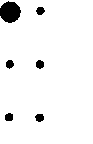

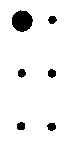

Results:
NCC mode:
1. :2/a scores: 1.0
2. :2/b scores: 0.976608116641
3. :2/b scores: 0.968681499718
Result:ha
Processed: 2/12
Processing:


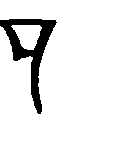

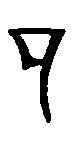

Results:
NCC mode:
1. :3/p scores: 0.998821039119
2. :14/t scores: 0.895534505299
3. :8/x scores: 0.887534550751
Result:hap
Processed: 3/12
Processing:


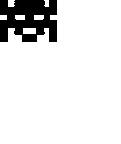

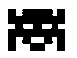

Results:
NCC mode:
1. :4/p scores: 1.0
2. :4/h scores: 0.762450931114
3. :18/f scores: 0.749991236423
Result:happ
Processed: 4/12
Processing:


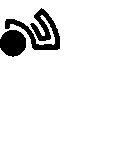

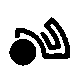

Results:
NCC mode:
1. :5/y scores: 0.99812815982
2. :17/m scores: 0.864077275504
3. :25/u scores: 0.859047795438
Result:happy
Processed: 5/12
Processing:


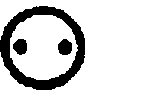

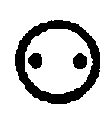

Results:
NCC mode:
1. :10/n scores: 1.0
2. :12/d scores: 0.977313402314
3. :12/b scores: 0.976792215381
Result:happy n
Processed: 6/12
Processing:


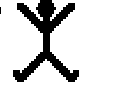

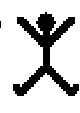

Results:
NCC mode:
1. :11/e scores: 0.996766406672
2. :3/h scores: 0.915247422477
3. :25/r scores: 0.90520015797
Result:happy ne
Processed: 7/12
Processing:


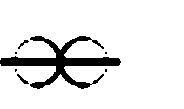

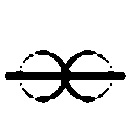

Results:
NCC mode:
1. :13/w scores: 1.0
2. :18/o scores: 0.990927147303
3. :5/m scores: 0.978537858584
Result:happy new
Processed: 8/12
Processing:


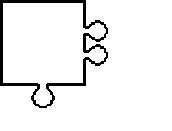

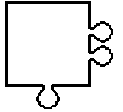

Results:
NCC mode:
1. :6/y scores: 1.0
2. :6/o scores: 0.998743021507
3. :6/o scores: 0.998666143081
Result:happy new y
Processed: 9/12
Processing:


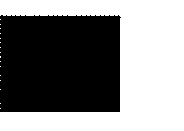

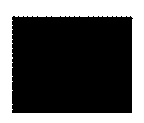

Results:
NCC mode:
1. :7/e scores: 1.0
2. :15/m scores: 0.749275306936
3. :4/e scores: 0.655539688711
Result:happy new ye
Processed: 10/12
Processing:


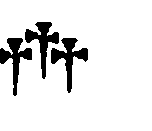

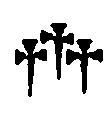

Results:
NCC mode:
1. :8/a scores: 1.0
2. :18/o scores: 0.920421115467
3. :10/i scores: 0.918832443809
Result:happy new yea
Processed: 11/12
Processing:


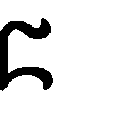

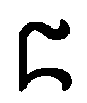

Results:
NCC mode:
1. :9/r scores: 1.0
2. :9/r scores: 0.970765480417
3. :9/l scores: 0.913771950136
Result:happy new year
Processed: 12/12
Processing:
Message: happy new year 


In [16]:
main()